# Production rate

We saw the production rate is not constant. In this notebook we fit functions to represent $q_P$.

In [1]:
import scripts.model_exp as model_exp
import scripts.plot_results as plot_results
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn
import scipy.optimize
import pickle
import collections
import os

plt.rc('font', size=14)


In [2]:
dir = "plots/qP/"
if not os.path.exists(dir):
    os.makedirs(dir)

with open("data/basic_parameters.p", "rb") as file:
    parameter = pickle.load(file)

Dfs = collections.namedtuple("Dfs", "all, growth, lin")
with open("data/flows.p", "rb") as file:
    dfs = pickle.load(file)

qm = parameter["qm"]


fit for $q_P^G$

In [3]:
dfs.growth["qG_qm"] = dfs.growth.qG - qm
dfs.all["qG_qm"] = dfs.all.qG - qm
df_growth = dfs.growth[dfs.growth.index < 35].copy()


def qP_qG(qG, qP_max, km):
    return qP_max * qG / (km + qG)


opt, cov = scipy.optimize.curve_fit(f=qP_qG, xdata=df_growth.qG_qm, ydata=df_growth.qP)
qP_max, km = opt
opt


array([0.02352561, 0.43608326])

In [4]:
np.sqrt(np.diag(cov))


array([0.00869855, 0.21673587])

fit for $q_P^X$

In [5]:
def qP_X(X, k, d):
    return k * X + d


opt, cov = scipy.optimize.curve_fit(f=qP_X, xdata=df_growth.X_av, ydata=df_growth.qP)
k, d = opt
opt


array([-0.000336  ,  0.01274906])

In [6]:
np.sqrt(np.diag(cov))


array([2.60972742e-05, 7.06695567e-04])

fit for $q_P^\mu$

In [7]:
def qP_mu(mu, qP_min, qP_max, kM):
    return qP_min + qP_max * mu / (kM + mu)


opt, cov = scipy.optimize.curve_fit(
    f=qP_mu,
    xdata=df_growth.mu,
    ydata=df_growth.qP,
    bounds=((0), (np.inf)),  # avoid negative value for qP_min
)
qP_min, qP_max_mu, kM = opt
opt


array([4.20237470e-10, 1.91329568e-02, 1.66036535e-01])

In [8]:
np.sqrt(np.diag(cov))


array([0.00151494, 0.01070817, 0.19860013])

fit for $q_P^n$

In [9]:
def qP_n(n, qP_max, n_max, kMn):
    return np.maximum(qP_max * (n_max - n) / (kMn + n_max - n), 0)


opt, cov = scipy.optimize.curve_fit(
    f=qP_n, xdata=df_growth.n, ydata=df_growth.qP, method="lm", p0=[0.02, 4.5, 2.7]
)
qP_max_n, n_max, kMn = opt
opt


array([0.01684681, 4.58900533, 1.53892374])

In [10]:
np.sqrt(np.diag(cov))


array([0.00591337, 0.06464716, 0.96689645])

Plot the fitted values for each assumption.

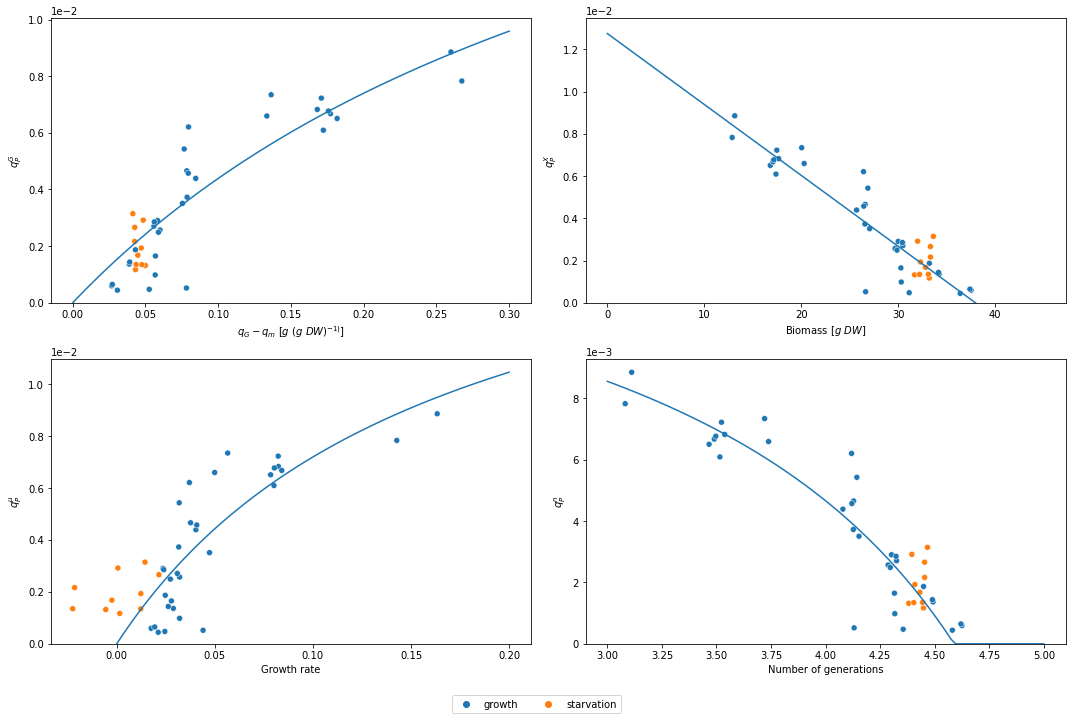

In [11]:
# plot qP against qG - qm, qG, mu, X

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
seaborn.scatterplot(
    data=dfs.all, x="qG_qm", y="qP", hue="starvation", ax=ax1, legend=False
)
x = np.linspace(0, 0.30, 100)
ax1.plot(x, qP_qG(x, qP_max, km))
ax1.set_xlabel("$q_G - q_m \\ [g \\ (g \\ DW)^{-1)}]$")
ax1.set_ylabel(r"$q_P^G$")

seaborn.scatterplot(data=dfs.all, x="X_av", y="qP", hue="starvation", ax=ax2)
x = np.linspace(0, 45, 100)
ax2.plot(x, qP_X(x, k, d))
ax2.set_xlabel("Biomass $[g \\ DW]$")
ax2.set_ylabel(r"$q_P^X$")
ax2.get_legend().remove()

seaborn.scatterplot(
    data=dfs.all, x="mu", y="qP", hue="starvation", ax=ax3, legend=False
)
x = np.linspace(0, 0.2, 100)
ax3.plot(x, qP_mu(x, qP_min, qP_max_mu, kM))
ax3.set_xlabel("Growth rate")
ax3.set_ylabel(r"$q_P^{\mu}$")

seaborn.scatterplot(data=dfs.all, x="n", y="qP", hue="starvation", ax=ax4, legend=False)
x = np.linspace(3, 5, 100)
ax4.plot(x, qP_n(x, qP_max_n, n_max, kMn))
ax4.set_xlabel("Number of generations")
ax4.set_ylabel(r"$q_P^n$")

[
    ax.set_ylim(
        0,
    )
    for ax in (ax1, ax2, ax3, ax4)
]

[
    ax.ticklabel_format(axis="y", style="sci", scilimits=(-1, 2))
    for ax in (ax1, ax2, ax3, ax4)
]

fig.tight_layout()

fig.subplots_adjust(bottom=0.1)
fig.legend(loc="lower center", ncol=2)

plt.savefig("plots/qP/compare_qP.png", bbox_inches="tight")
plt.show()


In [12]:
# save paramater for later use

parameter["X0"] = 1.52
parameter["V0"] = 0.5
parameter["V_end"] = 1
parameter["P0"] = 0

parameter_qG = parameter.copy()
parameter_qG["qP_parameter"] = {"qP_max": qP_max, "km": km}

parameter_X = parameter.copy()
parameter_X["qP_parameter"] = {"k": k, "d": d}

parameter_mu = parameter.copy()
parameter_mu["qP_parameter"] = {"qP_max": qP_max_mu, "qP_min": qP_min, "kM": kM}

parameter_n = parameter.copy()
parameter_n["qP_parameter"] = {"qP_max": qP_max_n, "n_max": n_max, "kMn": kMn}

parameter["km"] = km
parameter["qP_max"] = qP_max

with open("data/parameters.p", "wb") as file:
    pickle.dump(parameter, file)

with open("data/parameters_qG.p", "wb") as file:
    pickle.dump(parameter_qG, file)

with open("data/parameters_X.p", "wb") as file:
    pickle.dump(parameter_X, file)

with open("data/parameters_mu.p", "wb") as file:
    pickle.dump(parameter_mu, file)

with open("data/parameters_n.p", "wb") as file:
    pickle.dump(parameter_n, file)


Show effect of growth rate on production rate (for $q_P^G$)

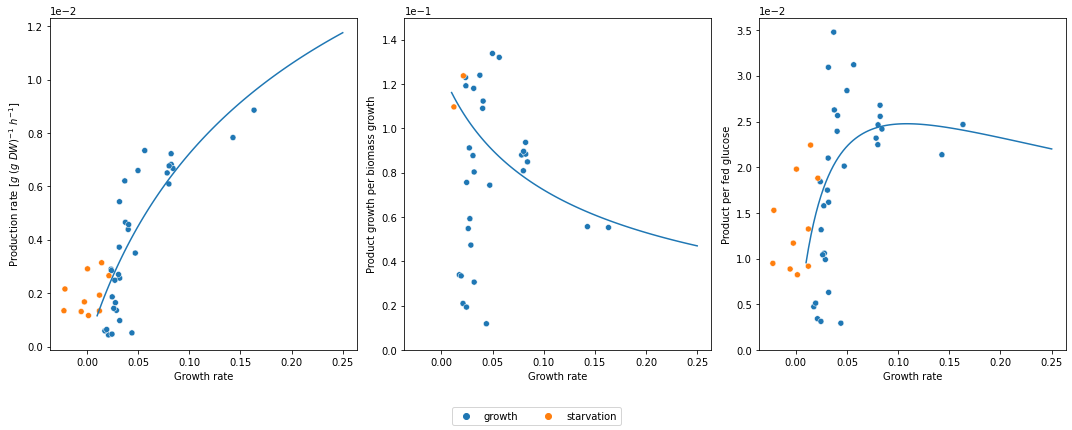

In [13]:
mod = model_exp.Model(**parameter)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=[15, 6])
mu = np.linspace(0.01, 0.25, 100)
qP = [mod.qP(x) for x in mu]
d_X_P = [x / y for x, y in zip(qP, mu)]
dP_dG = [P / (P / mod.Ypg + m / mod.Yxg + mod.qm) for P, m in zip(qP, mu)]
ax1.plot(mu, qP)
ax2.plot(mu, d_X_P)
ax3.plot(mu, dP_dG)
[ax.set_xlabel("Growth rate") for ax in [ax1, ax2, ax3]]
ax1.set_ylabel("Production rate $[g \\ (g \\ DW)^{-1} \\ h^{-1}]$")
ax2.set_ylabel("Product growth per biomass growth")
ax3.set_ylabel("Product per fed glucose")
[
    ax.ticklabel_format(axis="y", style="sci", scilimits=(-1, 2))
    for ax in (ax1, ax2, ax3)
]

    
seaborn.scatterplot(
    x=dfs.all.mu,
    y=dfs.all.qP,
    ax=ax1,
    hue=dfs.all.starvation,
)
    
seaborn.scatterplot(
    x=dfs.all.mu,
    y=dfs.all.dP / dfs.all.dX,
    ax=ax2,
    hue=dfs.all.starvation,
    legend=False,)

seaborn.scatterplot(
    x=dfs.all.mu,
    y=dfs.all.qP / dfs.all.qG,
    ax=ax3,
    hue=dfs.all.starvation,
    legend=False,)

ax2.set_ylim(0, 0.15)
ax3.set_ylim(0,)

fig.tight_layout()

ax1.get_legend().remove()
fig.subplots_adjust(bottom=0.18)
fig.legend(loc="lower center", ncol=2)

plt.savefig('plots/qP/product_depending_on_mu.png', facecolor="white", bbox_inches="tight")
plt.show()
